   # Convolutional Neural Networks with Pytorch for CIFAR 10 dataset
   
   - Developed by **Armin Norouzi**
   - Compatible with Google Colaboratory- Pytorch version 1.12.1+cu113

   
   - **Objective:** Create full Convolutional Neural Networks and train it for image classification
   





In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
import seaborn as sn  # for heatmaps
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

## Load the CIFAR dataset

The <a href='https://en.wikipedia.org/wiki/CIFAR-10'>CIFAR-10</a> dataset is similar to MNIST, except that instead of one color channel (grayscale) there are three channels (RGB).<br>
Where an MNIST image has a size of (1,28,28), CIFAR images are (3,32,32). There are 10 categories an image may fall under:
0. airplane
1. automobile
2. bird
3. cat
4. deer
5. dog
6. frog
7. horse
8. ship
9. truck

As with the previous code along, make sure to watch the theory lectures! You'll want to be comfortable with:
* convolutional layers
* filters/kernels
* pooling
* depth, stride and zero-padding

PyTorch makes the CIFAR-10 train and test datasets available through <a href='https://pytorch.org/docs/stable/torchvision/index.html'><tt><strong>torchvision</strong></tt></a>. The first time they're called, the datasets will be downloaded onto your computer to the path specified. From that point, torchvision will always look for a local copy before attempting another download.<br>The set contains 50,000 train and 10,000 test images.

Refer to the previous section for explanations of transformations, batch sizes and <a href='https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader'><tt><strong>DataLoader</strong></tt></a>.

In [2]:
transform = transforms.ToTensor()

train_data = datasets.CIFAR10(root='../Data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='../Data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../Data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [4]:
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ../Data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [5]:
torch.manual_seed(101)  # for reproducible results

train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

### Define strings for labels
We can call the labels whatever we want, so long as they appear in the order of 'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'. Here we're using 5-character labels padded with spaces so that our reports line up later.

In [6]:
class_names = ['plane', '  car', ' bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']

### View the image

Matplotlib can interpret pixel values through a variety of <a href='https://matplotlib.org/tutorials/colors/colormaps.html'>colormaps</a>.

Label: [    1     5     8     1     6     1     6     3     7     9]
Class:    car   dog  ship   car  frog   car  frog   cat horse truck


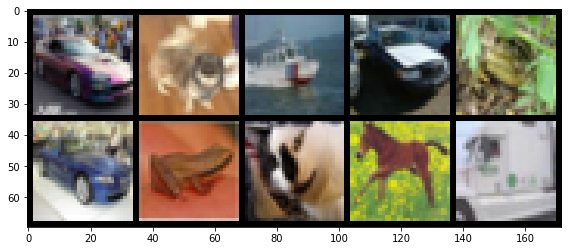

In [7]:
np.set_printoptions(formatter=dict(int=lambda x: f'{x:5}')) # to widen the printed array

# Grab the first batch of 10 images
for images,labels in train_loader: 
    break

# Print the labels
print('Label:', labels.numpy())
print('Class: ', *np.array([class_names[i] for i in labels]))

# Print the images
im = make_grid(images, nrow=5)  # the default nrow is 8
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

## Define a convolutional model

### Building model


* take in 3-channel images instead of 1-channel
* adjust the size of the fully connected input<br>

Our first convolutional layer will have 3 input channels, 6 output channels, a kernel size of 3 (resulting in a 3x3 filter), and a stride length of 1 pixel.<br>These are passed in as <tt>nn.Conv2d(3,6,3,1)</tt


In [8]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)  # changed from (1, 6, 5, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(6*6*16, 120)   # changed from (4*4*16) to fit 32x32 images with 3x3 filters
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 6*6*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

<div class="alert alert-info"><strong>Why <tt>(6x6x16)</tt> instead of <tt>(5x5x16)</tt>?</strong><br>
With MNIST the kernels and pooling layers resulted in $\;(((28−2)/2)−2)/2=5.5 \;$ which rounds down to 5 pixels per side.<br>
With CIFAR the result is $\;(((32-2)/2)-2)/2 = 6.5\;$ which rounds down to 6 pixels per side.</div>

In [9]:
torch.manual_seed(101)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [10]:
def count_parameters(model):
    ''' This function used for counting number of parameters

    Arg:
      Model (PyTorch object)

    Return:
      print number of paramteres in each layer and sum of laerning parameter number
    '''
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

In [11]:
count_parameters(model)

   162
     6
   864
    16
 69120
   120
 10080
    84
   840
    10
______
 81302


## Define loss function & optimizer

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Train the model
This time we'll feed the data directly into the model without flattening it first.

In [13]:
import time
start_time = time.time()

epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b += 1
        
        # Apply the model
        y_pred = model(X_train)  # we don't flatten X-train here
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%1000 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/60000]  loss: {loss.item():10.8f}')
        
    train_losses.append(loss.detach().numpy())
    train_correct.append(trn_corr.detach().numpy())
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss.detach().numpy())
    test_correct.append(tst_corr.detach().numpy())
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed            

epoch:  0  batch: 1000 [ 10000/60000]  loss: 1.77247238
epoch:  0  batch: 2000 [ 20000/60000]  loss: 2.24799037
epoch:  0  batch: 3000 [ 30000/60000]  loss: 1.38132501
epoch:  0  batch: 4000 [ 40000/60000]  loss: 1.74647105
epoch:  0  batch: 5000 [ 50000/60000]  loss: 0.82841432
epoch:  1  batch: 1000 [ 10000/60000]  loss: 1.37874842
epoch:  1  batch: 2000 [ 20000/60000]  loss: 1.32706583
epoch:  1  batch: 3000 [ 30000/60000]  loss: 1.26955664
epoch:  1  batch: 4000 [ 40000/60000]  loss: 1.01580548
epoch:  1  batch: 5000 [ 50000/60000]  loss: 0.89489520
epoch:  2  batch: 1000 [ 10000/60000]  loss: 1.23458266
epoch:  2  batch: 2000 [ 20000/60000]  loss: 0.80638343
epoch:  2  batch: 3000 [ 30000/60000]  loss: 1.17650115
epoch:  2  batch: 4000 [ 40000/60000]  loss: 1.44486666
epoch:  2  batch: 5000 [ 50000/60000]  loss: 1.07484591
epoch:  3  batch: 1000 [ 10000/60000]  loss: 1.53526032
epoch:  3  batch: 2000 [ 20000/60000]  loss: 1.02132344
epoch:  3  batch: 3000 [ 30000/60000]  loss: 0.8

## Plot the loss and accuracy comparisons

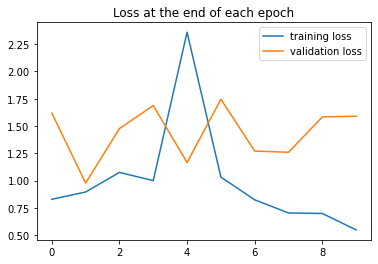

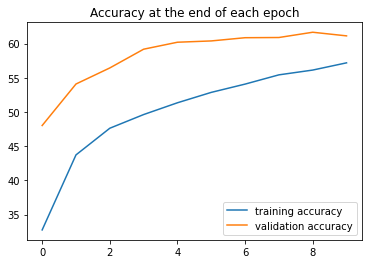

In [14]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend()
plt.show();

plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend()
plt.show();

## Evaluate Test Data

In [15]:
print(test_correct) # contains the results of all 10 epochs
print()
print(f'Test accuracy: {test_correct[-1].item()*100/10000:.3f}%') # print the most recent result as a percent

[array( 4802), array( 5409), array( 5644), array( 5918), array( 6020), array( 6039), array( 6086), array( 6089), array( 6166), array( 6113)]

Test accuracy: 61.130%


### Display the confusion matrix

In order to map predictions against ground truth, we need to run the entire test set through the model.<br>
Also, since our model was not as accurate as with MNIST, we'll use a <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>heatmap</a> to better display the results.

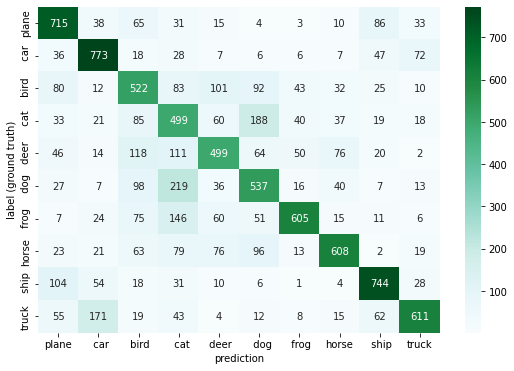

In [16]:
# Create a loader for the entire the test set
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()

arr = confusion_matrix(y_test.view(-1), predicted.view(-1))
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();

## Examine the misses
We can track the index positions of "missed" predictions, and extract the corresponding image and label. We'll do this in batches to save screen space.

In [17]:
misses = np.array([])
for i in range(len(predicted.view(-1))):
    if predicted[i] != y_test[i]:
        misses = np.append(misses,i).astype('int64')
        
# Display the number of misses
len(misses)

3887

In [18]:
# Set up an iterator to feed batched rows
r = 12   # row size
row = iter(np.array_split(misses,len(misses)//r+1))

Index: [    4     8    17    19    21    24    25    28    30    31    32    33]
Label: [    6     3     7     6     0     5     2     9     6     5     4     5]
Guess: [    4     2     3     3     2     4     5     1     3     3     2     3]


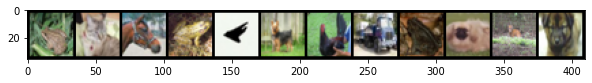

In [19]:
nextrow = next(row)
print("Index:", nextrow)
print("Label:", y_test.index_select(0,torch.tensor(nextrow)).numpy())
print("Guess:", predicted.index_select(0,torch.tensor(nextrow)).numpy())

images = X_test.index_select(0,torch.tensor(nextrow))
im = make_grid(images, nrow=r)
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

## References: 

- [PyTorch for Deep Learning with Python Bootcamp](https://www.udemy.com/course/pytorch-for-deep-learning-with-python-bootcamp/) by [Jose Marcial Portilla](https://www.linkedin.com/in/jmportilla/)